In [1]:
!pip install tensorboardX
!pip install icecream

In [2]:
import os
import sys

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.utils as vutils

# Required for PAN.
import tensorboardX
import tqdm
import sklearn

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
# Better than print(): use ic()
from icecream import ic

# from google.colab import drive
# drive.mount('/content/gdrive')

# Set a random seed for predictable behavior
torch.manual_seed(6862)

In [3]:
# Clone PAN library if it doesn't already exist in the content/ directory (which is hopefully mounted).
if not os.path.isdir('PAN-PyTorch'):
  !git clone https://github.com/zhang-can/PAN-PyTorch.git

# Same for TSN.
if not os.path.isdir('/content/temporal-segment-networks'):
  !git clone https://github.com/yjxiong/temporal-segment-networks

# Same for VideoFrameDataLoader utils.
if not os.path.isdir('/content/Video-Dataset-Loading-Pytorch'):
  !git clone https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch

# And the Moments in Time Model repo, which provides tools to turn videos to frames.
if not os.path.isdir('moments_models'):
  !git clone https://github.com/zhoubolei/moments_models

sys.path.insert(1,'/content/PAN-PyTorch')
sys.path.insert(2,'/content/temporal-segment-networks')
sys.path.insert(3,'/content/moments_models')
sys.path.insert(4,'/content/Video-Dataset-Loading-Pytorch')

# Import Persistence-of-Appearance module from PAN.
from ops.PAN_modules import PA
from ops.transforms import ToTorchFormatTensor
# Import VideoFrameDataset
from video_dataset import VideoFrameDataset, ImglistToTensor

In [4]:
'''
Download the simplest 2-class toy data, already split into frames:
moments2classes/
-- training/
   |-- clapping/
      |-- clapping1/ # video sample file
           |-- <frame_01>.jpg
           |-- <frame_02>.jpg
           |-- ...
      |-- clapping2/
           |-- ...
      |-- .../
   |-- constructing/
      |-- construction01/
           |-- ...
'''

if not os.path.isfile('moments2classes.zip'):
  !wget 'https://www.dropbox.com/s/6rdvj8qr2foju90/moments2classes.zip'

if not os.path.isdir('moments2classes'):
  !unzip 'moments2classes.zip'

In [5]:
!ls
data_dir = 'moments_subset_2/'

annotations.txt      moments_models    sample_data
moments2classes      moments_subset_2  temporal-segment-networks
moments2classes.zip  PAN-PyTorch       Video-Dataset-Loading-Pytorch


In [6]:
# Prepare a file that describes the dataset as per TSN.
# (Include the trailing period `.` in your URL. Sigh.)
# https://github.com/yjxiong/temporal-segment-networks/wiki/Working-on-custom-datasets.

# Define a "parser" for the dataset.
def parse_moments_in_time():
  '''
  Return a TSN-conforming video file list that decribe the dataset, i.e.:
  [ # dataset XX
    (
         [(filename_1, label_1), (filename_2, label_2),...], # train subset
         [(filename_10, label_10), (filename_20, label_20])...] # test subset
    ), #split 1
    (
         [(filename_3, label_3), (filename_7, label_7),...], # train subset
         [(filename_10, label_10), (filename_15, label_15])...] # test subset
    ) #split 2
  ]
  '''
  # One split in the moments dataset as-is: 'training/' and 'validation/' folders.
  data_dir = 'moments_subset_2/'
  training_dir = os.path.join(data_dir, 'training/')
  validation_dir = os.path.join(data_dir, 'validation/')
  dataset = []
  training_subset = []
  validation_subset = []

  for label_index, item in enumerate(os.listdir(training_dir)):
    for video_filename in os.listdir(os.path.join(training_dir, item)):
      training_subset.append((video_filename, label_index))

  for label_index, item in enumerate(os.listdir(validation_dir)):
    for video_filename in os.listdir(os.path.join(validation_dir, item)):
      validation_subset.append((video_filename, label_index))

  only_split = (training_subset, validation_subset)

  return [only_split]

In [7]:
# Prepare file lists that describe videos, as PAN seems to describe here:
# https://github.com/zhang-can/PAN-PyTorch#data-preparation
# TODO: GENERALIZE BEYOND OUR MINI SUBSET OF DATA
def prepare_file_list_a_la_PAN():
  '''
  Each line of the list file will contain a tuple of:
  (extracted video frame folder name, video frame number, and video groundtruth class).
  A list file looks like this:
     video_frame_folder   100  10
     video_2_frame_folder 150  31
     ...
  '''

  pass

In [8]:
# FROM HW COLAB: Probes the module and returns the string representation of
# its layers, if they are nn.Sequential types.
def get_modules(module_object):
    '''
    gets a list of modules without nn.Sequential groupings, as a list of strings
    '''
    modules_list = []
    for module in module_object.children():
        if isinstance(module, nn.Sequential):
            modules_list += get_modules(module)
        else:
            modules_list.append(str(module))
    return modules_list

In [9]:
# Demo PA module.
# PA_module = PA(n_length=2) # adjacent '2' frames are sampled for computing PA
# shape of x: [N*T*m, 3, H, W]
# x = torch.randn(5*8*4, 3, 224, 224)
# shape of PA_out: [N*T, m-1, H, W]
# PA_out = PA_module(x) # torch.Size([40, 3, 224, 224])

In [10]:
root_training_data_path = 'moments2classes/training/'
annotations_file = 'annotations.txt'

preprocess = transforms.Compose([
    ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
])

# Load single, continuous tensors without any temporal sampling.
# i.e. load all frames
dataset = VideoFrameDataset(
    root_path=root_training_data_path,
    annotationfile_path=annotations_file,
    num_segments=1,
    frames_per_segment=18,  # SMALLEST AMOUNT OF FRAMES IN A SAMPLE
    imagefile_template='f{:04d}.jpg',  # 4 digits in our naming convention here
    transform=preprocess,
    random_shift=False,
    test_mode=False
)

In [11]:
sample = dataset[0]  # take first sample of dataset 
frames = sample[0]   # list of processed images
label = sample[1]    # integer label

In [12]:
def plot_video(rows, cols, frame_list, plot_width, plot_height):
    fig = plt.figure(figsize=(plot_width, plot_height))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    for index, (ax, im) in enumerate(zip(grid, frame_list)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title(index)
    plt.show()

In [13]:
dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2,  # max suggested by runtime
    pin_memory=True
)

In [14]:
# Each processed video tensor has shape (BATCH x FRAMES x CHANNELS x WIDTH x HEIGHT)
for video_batch, labels in dataloader:
  print("Labels:", labels)
  print("Video Batch Tensor Size:", video_batch.size())
  print("Batch Labels Size:", labels.size())
  print("")

Labels: tensor([0])
Video Batch Tensor Size: torch.Size([1, 18, 3, 240, 320])
Batch Labels Size: torch.Size([1])

Labels: tensor([0])
Video Batch Tensor Size: torch.Size([1, 18, 3, 360, 480])
Batch Labels Size: torch.Size([1])

Labels: tensor([1])
Video Batch Tensor Size: torch.Size([1, 18, 3, 404, 1280])
Batch Labels Size: torch.Size([1])

Labels: tensor([1])
Video Batch Tensor Size: torch.Size([1, 18, 3, 256, 384])
Batch Labels Size: torch.Size([1])



In [15]:
PA_module = PA(n_length=2) # adjacent 1 frames are sampled for computing PA
PA_outs = []
for video_batch, labels in dataloader:
  # batch=1, so get rid of the extra dimension
  squeezed = torch.squeeze(video_batch)
  out = PA_module(squeezed)
  ic(squeezed.size(), out.size())
  PA_outs.append(out)

ic| squeezed.size(): torch.Size([18, 3, 360, 480])
    out.size(): torch.Size([9, 1, 360, 480])
ic| squeezed.size(): torch.Size([18, 3, 404, 1280])
    out.size(): torch.Size([9, 1, 404, 1280])
ic| squeezed.size(): torch.Size([18, 3, 240, 320])
    out.size(): torch.Size([9, 1, 240, 320])
ic| squeezed.size(): torch.Size([18, 3, 256, 384])
    out.size(): torch.Size([9, 1, 256, 384])


In [16]:
def show(tensor):
   npimg = tensor.detach().numpy()
   plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

torch.Size([9, 1, 360, 480])


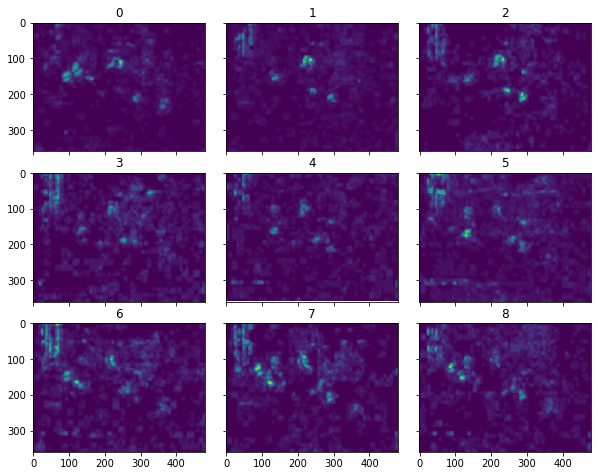

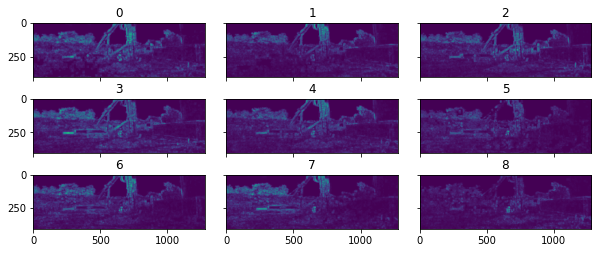

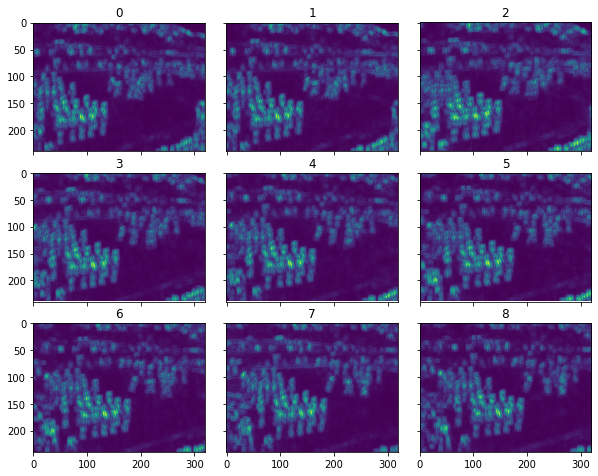

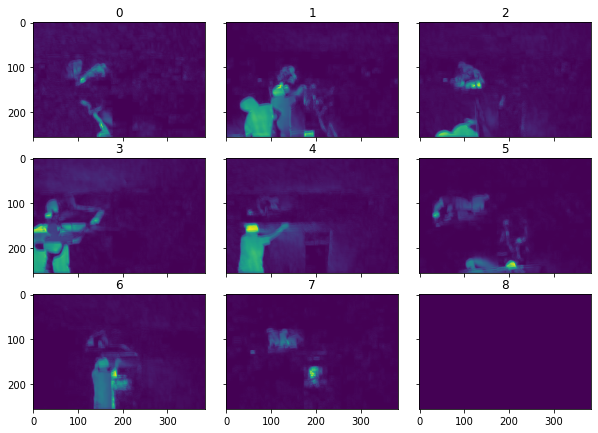

In [17]:
print(PA_outs[0].detach().size())
def plottable(tsr):
  return torch.squeeze(tsr.detach())

for im in PA_outs:
  plot_video(3, 3, plottable(im), 10., 10.)
